<a href="https://colab.research.google.com/github/petre001/PET_Biomarkers/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting PET Biomarkers of Alzheimer’s Disease With MRI Using Deep Convolutional Neural Networks 
### Contributors: Jeffrey Petrella

This project uses transfer learning to train a ResNet18 model to identify amyloid PET biomarker status from MRI images. It should be run on a GPU

### Step 1: Link Notebook to GitHub

In [15]:
# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "PET_Biomarkers" # Enter repo name
git_path = 'https://github.com/petre001/PET_Biomarkers.git'
!git clone "{git_path}"

rm: cannot remove './sample_data': No such file or directory
Cloning into 'PET_Biomarkers'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 53 (delta 20), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (53/53), done.


### Step 2: Install and Import Dependencies

In [16]:
# Change working directory to location of notebook
# import os
# notebook_dir = ''
# path_to_notebook = os.path.join(repo_name,notebook_dir)
# path_to_notebook
%cd "{repo_name}"

/content/drive/MyDrive/mci_data/PET_Biomarkers


In [17]:
# Install dependencies from requirements.txt file
!pip install -r "{'requirements.txt'}"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 5.1 MB/s 


In [18]:
import os
import urllib.request
import tarfile
import copy
import time
import numpy as np
import pandas as pd
from torchsummary import summary
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import pydicom
import cv2
from PIL import Image

import torch
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

torch:  1.11 ; cuda:  cu113


### Step 3: Load Training and Test data

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
%cd /content/drive/MyDrive/mci_data

/content/drive/MyDrive/mci_data


In [22]:
print(os.environ['PATH'])

/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin


In [ ]:
# Load training and test data
def npy_loader(path):
    sample = torch.from_numpy(np.load(path))
    return sample
    

dataset = datasets.DatasetFolder(
    root='PATH',
    loader=npy_loader,
    extensions=['.npy']
)

In [ ]:
# Load training and test data

# Set up transforms - ToTensor only in this case
data_transform = transforms.Compose([transforms.ToTensor()]) # Converts pixel values to tensor in range [0.,1.]

# Set up datasets
train_data = FashionMNIST(root='data', train=True,
                                   download=True, transform=data_transform)

test_data = FashionMNIST(root='data', train=False,
                                  download=True, transform=data_transform)

print('Training data images: ', len(train_data))
print('Test data images: ', len(test_data))

# Specify the image classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Set random seeds for reproducibility
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)

In [ ]:
url

'https://duke.app.box.com/folder/164326933420?s=pdk6boddtcwwm1y4o9hn0quw2b4yghs5'

In [ ]:
# Download the data
if not os.path.exists('./data'):
    os.mkdir('./data')
if not os.path.exists('data/siim_small'):
    url = 'https://s3.amazonaws.com/fast-ai-imagelocal/siim_small.tgz'
    urllib.request.urlretrieve(url,filename='data/siim_small.tgz')
    file = tarfile.open('data/siim_small.tgz')
    file.extractall('data')
    file.close()

### Step 3: Load Model and Demo Images

This Model is a ResNet18 model that has been updated and trained with an average MAE of 5 years over 10 test sets.  

There are 10 images provided in image_data.zip for demonstration purposes: 





![](https://raw.githubusercontent.com/MRWilliamsGit/BrainAgingComputerVision/main/images/examples.png?raw=true)

In [ ]:
#unzip example images
!unzip '/content/BrainAgingComputerVision/sample_data/image_data.zip' > /dev/null
images = [f for f in os.listdir('/content') if os.path.isfile(os.path.join('/content', f))]

In [ ]:
#get image metadata
filein = '/content/BrainAgingComputerVision/sample_data/cn_age_df.csv'
CNdata = pd.read_csv(filein)
filein = '/content/BrainAgingComputerVision/sample_data/ad_age_df.csv'
ADdata = pd.read_csv(filein)

In [ ]:
#load model
model = torch.load('/content/BrainAgingComputerVision/models/model.pt')

### Step 4: Choose Image 

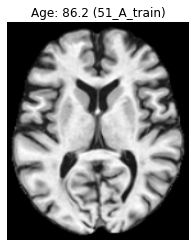

In [ ]:
#Pick one of the 10 images to see it and see its age
pick = 0

#open the image
here = os.path.join('/content/',images[pick-1])
image_3D = np.load(here)
im = Image.fromarray((image_3D[85] * 255).astype(np.uint8))
im = np.rot90(im)

#plot the image
plt.imshow(im, interpolation='nearest', cmap='gray')
imgn = images[pick-1].split(".")[0]
line = CNdata.loc[CNdata['Data ID'] == imgn]
if len(line)>0:
  label = line.iloc[0][5]
  plt.title("Age: " + str(label)+ " (" +str(imgn) +")")
  plt.axis('off');
else:
  line = ADdata.loc[ADdata['Data ID'] == imgn]
  label = line.iloc[0][5]
  plt.title("Age: " + str(label)+ "(" +str(imgn) +")")
  plt.axis('off');  


### Step 5: Get Prediction!

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#get prediction
img = (image_3D[85] * 255).astype(np.uint8)
image = SingleLoader(img)
pred = SinglePredict(model, image, device)
print("Pred: "+str(pred))

Pred: 87.5


### Step 6: AD Application

This model has been trained on cognitively normal subjects, but it interests us to see how this model would perform on subjects with degenerative brain disease such as Alzheimer's. Would the model estimate the brain to be older than it is chronologically?

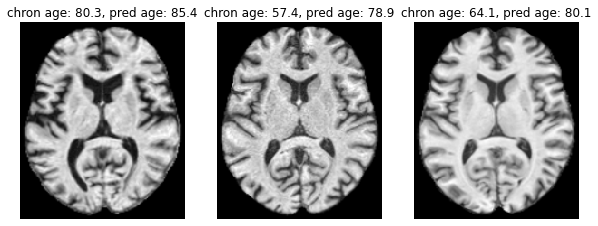

In [ ]:
#get AD images
!unzip '/content/BrainAgingComputerVision/sample_data/image_data_AD.zip' > /dev/null
images = ['2_N_test.npy', '4_T_test.npy', '7_A_test.npy']

#show them with their predictions
plt.rcParams['figure.figsize'] = [10, 5]
fig, axs = plt.subplots(1, 3)
i=0
for m in range(len(images)):
  #open the image
  here = os.path.join('/content/',images[m])
  image_3D = np.load(here)
  forpred = (image_3D[85] * 255).astype(np.uint8)
  #get prediction
  image = SingleLoader(forpred)
  pred = SinglePredict(model, image, device)
  #plot the image
  im = Image.fromarray((image_3D[85] * 255).astype(np.uint8))
  im = np.rot90(im)
  axs[m].imshow(im, interpolation='nearest', cmap='gray')
  imgn = images[m].split(".")[0]
  line = ADdata.loc[ADdata['Data ID'] == imgn]
  label = line.iloc[0][5]
  axs[m].set_title("chron age: " + str(label) + ", pred age: " + str(pred))
  axs[m].axis('off') 
